In [25]:
import pandas as pd
import numpy as np
import pickle
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, QuantileLoss, GroupNormalizer
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import lightning.pytorch as pl
from lightning.pytorch import Trainer
from lightning.pytorch.tuner import Tuner
import pytorch_optimizer
import matplotlib
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

In [26]:
content = pd.read_csv('data/Final Transactions.csv')
display(content)

,Count,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,0,2023-01-01 00:00:31,596,3156,533.07,31,0,0,0
1,1,1,2023-01-01 00:02:10,4961,3412,808.56,130,0,0,0
2,2,2,2023-01-01 00:07:56,2,1365,1442.94,476,0,1,1
3,3,3,2023-01-01 00:09:29,4128,8737,620.65,569,0,0,0
4,4,4,2023-01-01 00:10:34,927,9906,490.66,634,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1754150,1754150,1754150,2023-07-02 23:56:36,161,655,531.43,15810996,182,0,0
1754151,1754151,1754151,2023-07-02 23:57:38,4342,6181,10.40,15811058,182,0,0
1754152,1754152,1754152,2023-07-02 23:58:21,618,1502,26.62,15811101,182,0,0
1754153,1754153,1754153,2023-07-02 23:59:52,4056,3067,550.43,15811192,182,0,0


In [27]:
content['CUSTOMER_ID'].nunique()

4990

In [28]:
content.dropna(subset=["CUSTOMER_ID"], inplace=True)
content.drop(['Count'], axis=1,inplace=True)
print(len(content))

1754155


In [29]:
content['TX_DATETIME'] = pd.to_datetime(content['TX_DATETIME'])
content['CUSTOMER_ID'] = content['CUSTOMER_ID'].astype('str')
content['TERMINAL_ID'] = content['CUSTOMER_ID'].astype('str')
content.sort_values(by=['CUSTOMER_ID'], kind='mergesort')
content = content.sort_values(by='TX_DATETIME', kind='mergesort', ascending=False).reset_index(drop=True)
content.drop(['TX_TIME_SECONDS', 'TX_TIME_DAYS'], axis=1,inplace=True)
#content['time_idx'] = np.arange(len(content))
content["time_idx"] = content.groupby("CUSTOMER_ID").cumcount()
display(content)

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,TX_FRAUD_SCENARIO,time_idx
0,1754154,2023-07-02 23:59:57,3542,3542,216.57,0,0,0
1,1754153,2023-07-02 23:59:52,4056,4056,550.43,0,0,0
2,1754152,2023-07-02 23:58:21,618,618,26.62,0,0,0
3,1754151,2023-07-02 23:57:38,4342,4342,10.40,0,0,0
4,1754150,2023-07-02 23:56:36,161,161,531.43,0,0,0
...,...,...,...,...,...,...,...,...
1754150,4,2023-01-01 00:10:34,927,927,490.66,0,0,493
1754151,3,2023-01-01 00:09:29,4128,4128,620.65,0,0,598
1754152,2,2023-01-01 00:07:56,2,2,1442.94,1,1,337
1754153,1,2023-01-01 00:02:10,4961,4961,808.56,0,0,737


In [30]:
content["TX_FRAUD"] = content["TX_FRAUD"].astype("float32")
content["TX_AMOUNT"] = content["TX_AMOUNT"].astype("float32")
content["TX_FRAUD_SCENARIO"] = content["TX_FRAUD_SCENARIO"].astype("float32")

In [31]:
#groupNorm = GroupNormalizer(groups=["CUSTOMER_ID"], transformation="softplus")
#groupNorm.fit(content["TX_FRAUD"], content["CUSTOMER_ID"])

In [32]:
maxEncoderLength = 100
maxPredLength = 1
training = TimeSeriesDataSet( 
    content,
    time_idx='time_idx',
    target='TX_FRAUD',
    group_ids=['CUSTOMER_ID'],
    static_categoricals=['CUSTOMER_ID','TERMINAL_ID'],
    time_varying_unknown_reals=['TX_AMOUNT','TX_FRAUD_SCENARIO'],
    max_encoder_length=maxEncoderLength,
    max_prediction_length=maxPredLength,
    target_normalizer=GroupNormalizer(groups=["CUSTOMER_ID"]),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

/Users/craigjones/Documents/CBAProj/venv/lib/python3.11/site-packages/pytorch_forecasting/data/timeseries/_timeseries.py:1847: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 703 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__CUSTOMER_ID': '10'}, {'__group_id__CUSTOMER_ID': '1009'}, {'__group_id__CUSTOMER_ID': '1010'}, {'__group_id__CUSTOMER_ID': '1017'}, {'__group_id__CUSTOMER_ID': '1024'}, {'__group_id__CUSTOMER_ID': '1025'}, {'__group_id__CUSTOMER_ID': '1030'}, {'__group_id__CUSTOMER_ID': '1042'}, {'__group_id__CUSTOMER_ID': '1057'}, {'__group_id__CUSTOMER_ID': '106'}]
  warnings.warn(


In [33]:
batchSize = 128
trainDataloader = training.to_dataloader(
    train=True, batch_size=batchSize, num_workers = 2
)
validation = TimeSeriesDataSet.from_dataset(
    training, content, predict=True, stop_randomization=True
)
valDataloader = validation.to_dataloader(
    train=False,batch_size=batchSize*10, num_workers=2
)
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="auto",
    gradient_clip_val=0.1,
)
TFT = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate = 0.03,
    hidden_size=8,
    attention_head_size=3,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    optimizer="ranger",
)

/Users/craigjones/Documents/CBAProj/venv/lib/python3.11/site-packages/pytorch_forecasting/data/timeseries/_timeseries.py:1847: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 703 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__CUSTOMER_ID': '10'}, {'__group_id__CUSTOMER_ID': '1009'}, {'__group_id__CUSTOMER_ID': '1010'}, {'__group_id__CUSTOMER_ID': '1017'}, {'__group_id__CUSTOMER_ID': '1024'}, {'__group_id__CUSTOMER_ID': '1025'}, {'__group_id__CUSTOMER_ID': '1030'}, {'__group_id__CUSTOMER_ID': '1042'}, {'__group_id__CUSTOMER_ID': '1057'}, {'__group_id__CUSTOMER_ID': '106'}]
  warnings.warn(
Seed set to 42
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry

/Users/craigjones/Documents/CBAProj/venv/lib/python3.11/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
/Users/craigjones/Documents/CBAProj/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/craigjones/Documents/CBAProj/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
Finding best initial lr:  96%|█████████▌| 96/100 [00:46<00:01,  2.05it/s]
LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.004365158322401661
Restoring states from the checkpoint path at /Users/craigjones/Documents/CBAProj/src/.lr_find_a69b9ba2-abc2-4476-bb7

suggested learning rate: 0.004365158322401661


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
_pickle.UnpicklingError: pickle data was truncated


Epoch 0: 100%|██████████| 50/50 [23:45<00:00,  0.04it/s, v_num=5, train_loss_step=0.0963]


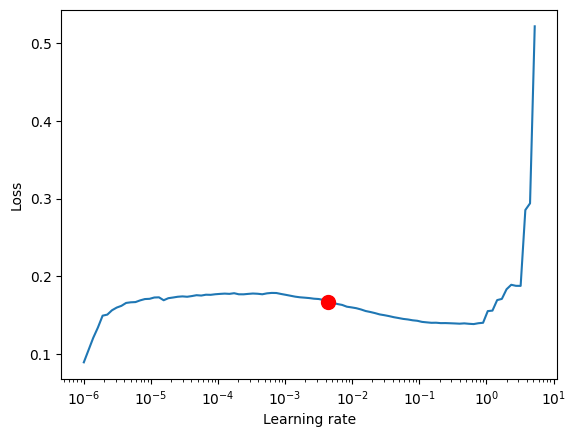

/var/folders/6y/5qkcjx755bdb5m9t_q7w943h0000gn/T/ipykernel_95970/3343767264.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [34]:
res = Tuner(trainer).lr_find(
    TFT,
    train_dataloaders=trainDataloader,
    val_dataloaders=valDataloader,
    max_lr=10.0,
    min_lr=1e-6
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [35]:
earlyStopper = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)
learningRateLogger = LearningRateMonitor()
logger = TensorBoardLogger(save_dir="lightning_logs", name="Model")

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="auto",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,
    callbacks=[learningRateLogger, earlyStopper],
    logger=logger,
)
biggerTFT = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,
    optimizer="ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {biggerTFT.size() / 1e3:.1f}k")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/craigjones/Documents/CBAProj/venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/craigjones/Documents/CBAProj/venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Number of parameters in network: 178.0k


In [36]:
trainer.fit(
    biggerTFT,
    train_dataloaders=trainDataloader,
    val_dataloaders=valDataloader,
)


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 159 K  | train
3  | prescalers                         | ModuleDict                      | 96     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 2.1 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.8 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528    | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/craigjones/Documents/CBAProj/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Users/craigjones/Documents/CBAProj/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 49: 100%|██████████| 50/50 [22:33<00:00,  0.04it/s, v_num=7, train_loss_step=0.0714, val_loss=0.072, train_loss_epoch=0.0756]   

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 50/50 [22:33<00:00,  0.04it/s, v_num=7, train_loss_step=0.0714, val_loss=0.072, train_loss_epoch=0.0756]


In [38]:
study = optimize_hyperparameters( 
    trainDataloader,
    valDataloader,
    model_path="optunaTest",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01,1.0),
    hidden_size_range=(8, 128),
    attention_head_size_range=(1,4),
    learning_rate_range=(0.001,0.1),
    dropout_range=(0.1,0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,
)

with open("testStudy.pkl", "wb") as fout:
    pickle.dump(study,fout)

print(study.best_trial.params)


[I 2025-07-29 22:33:15,732] A new study created in memory with name: no-name-7a6b828a-d2f0-4d5f-9fbb-84922b5d8137
/Users/craigjones/Documents/CBAProj/venv/lib/python3.11/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:142: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gradient_clip_val = trial.suggest_loguniform(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/craigjones/Documents/CBAProj/venv/lib/python3.11/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:168: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout=trial.suggest_uniform("dropout", *dropout